### Open File

In [276]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [277]:
df = pd.read_csv('./data/df_features.gz')

I delete the rows without a distance to city center (because in the origin hotel don't have latitude and longitude)

In [278]:
df = df.dropna(subset=['Dist_Center'])

In [279]:
df.Reservation_ADR = df.Reservation_ADR.fillna(df.Reservation_ADR.mean())
df.Price = df.Price.fillna(df.Price.mean())

In [280]:
sum(df.Price.isna()), sum(df.Reservation_ADR.isna())

(0, 0)

### Create Predicted Category for final models (2 categories)

In [281]:
diff_hotels = df[['Hotel_Address','Diff']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff.reset_index()

In [282]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [283]:
category = np.array(['Bad' if i < 7 else 'Good' for i in df.Reviewer_Score])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df) 

Good    0.831599
Bad     0.168401
Name: Category, dtype: float64

In [284]:
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score',
       'days_since_review', 'lat', 'lng', 'Diff', 'Diff_Percentage',
       'Review_Month', 'Review_Year', 'Country', 'City', 'Pet', 'Purpose',
       'Whom', 'Room', 'Length', 'Device', 'Room_Recode', 'Nationality_Recode',
       'Length_Recode', 'Close_Landmarks', 'Dist_Center', 'Dist_Airport',
       'Dist_Train', 'Price', 'Stars', 'Length_N', 'Reservation_ADR',
       'food_Neg', 'staff_Neg', 'location_Neg', 'value_Neg', 'comfort_Neg',
       'room_Neg', 'facilities_Neg', 'cleanliness_Neg', 'food_Pos',
       'staff_Pos', 'location_Pos', 'value_Pos', 'comfort_Pos', 'room_Pos',
       'facilities_Pos', 'cleanliness_Pos', 'food_Neg_Hotel',
       'staff_Neg_Hotel', 'loca

### Balance Nationalities and / or Categories

In [285]:
def balance_df(df, Balance_Nationality, Balance_Category):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = 20000
            if len(nationality) < 20000:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [286]:
df_balanced = balance_df(df, Balance_Nationality=True, Balance_Category=True)

### Prepare Data to run Models

In [287]:
df_model = df_balanced.sample(n=20000, random_state=1)

In [288]:
x_categorical = ['Review_Month', 'City', 'Pet', 'Purpose','Room_Recode', 'Whom', 'Nationality_Recode', 'Length_Recode',
                 'Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','count', 'mean', 'std', 'min', '25%', 
               '50%', '75%', 'max', 'Reservation_ADR', 'Price']
x_col = x_categorical + x_numerical
y_col = 'Category'

In [289]:
X_numerical = df_model[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [290]:
X_categorical = pd.get_dummies(df_model[x_categorical], prefix_sep='_', drop_first=True)
X_categorical = X_categorical.fillna('Not Available')

In [291]:
X = pd.concat([X_numerical_std, X_categorical], axis=1, sort=False)
y = df_model[y_col]

Split into Train and Test

In [292]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=100)

In [293]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((10000, 63), (10000,), (10000, 63), (10000,))

## MODELS

### Evaluate Model

In [342]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score

In [348]:
def evaluate(model):
    clf = model
    clf.fit(X_train, y_train)
    train = clf.predict(X_train)
    pred = clf.predict(X_test)
    print('Test :', f'{accuracy_score(pred, y_test):.4f}', '|', f'{cohen_kappa_score(pred, y_test):.4f}')
    print('Train:', f'{accuracy_score(train, y_train):.4f}', '|', f'{cohen_kappa_score(train, y_train):.4f}')
    return(pred)

### KNN

In [349]:
pred_knn = evaluate(KNeighborsClassifier(n_neighbors=5))

Test : 0.5992 | 0.1985
Train: 0.7289 | 0.4578


### Gradient Boosted Trees

In [350]:
pred_gbt = evaluate(GradientBoostingClassifier(learning_rate=0.04, max_depth=3, random_state=1))

Test : 0.6543 | 0.3089
Train: 0.6667 | 0.3336


### Random Forest

In [351]:
pred_rf = evaluate(RandomForestClassifier(n_estimators = 75, max_depth = 5, random_state=1))

Test : 0.6429 | 0.2860
Train: 0.6553 | 0.3108


### XGBoosting

In [352]:
pred_xgb = evaluate(xgb.XGBClassifier(objective="binary:logistic", n_estimators = 7, max_depth=4, random_state=1))

Test : 0.6473 | 0.2949
Train: 0.6612 | 0.3226


### Logistic Regresion

In [353]:
pred_log = evaluate(LogisticRegression(solver='lbfgs', max_iter=500, random_state=1))

Test : 0.6560 | 0.3120
Train: 0.6564 | 0.3127


### Decision Trees

In [354]:
pred_tree = evaluate(DecisionTreeClassifier(max_depth=4, random_state=1))

Test : 0.6376 | 0.2753
Train: 0.6490 | 0.2980


### SVM

In [201]:
pred_svm = evaluate(SVC(C=0.5, random_state=1))

Test : 0.6528 | 0.3057
Train: 0.6694 | 0.3387


### Naive Bayes

In [202]:
pred_nb = evaluate(BernoulliNB())

Test : 0.6460 | 0.2921
Train: 0.6383 | 0.2761


### Models Summary

In [132]:
df_models_test = pd.DataFrame(list(zip(y_test, pred_log, pred_knn, pred_xgb, pred_gbt, pred_rf, 
                                       pred_svm, pred_tree, pred_nb)), 
                         columns=['TEST','logistic','knn','xgb','gbt','rf','svm', 'tree', 'nb']) 
df_models_test.head()

,TEST,logistic,knn,xgb,gbt,rf,svm,tree,nb
0,Bad,Bad,Good,Bad,Bad,Bad,Bad,Good,Bad
1,Good,Good,Good,Good,Good,Good,Good,Good,Good
2,Bad,Bad,Bad,Bad,Good,Good,Bad,Bad,Good
3,Good,Bad,Bad,Bad,Bad,Bad,Bad,Bad,Bad
4,Good,Good,Bad,Good,Good,Good,Good,Good,Good


## ENSEMBLE

In [133]:
modelos = [('Logistic', LogisticRegression(solver='lbfgs', max_iter=1500, random_state=1)), 
           ('Random Forest', RandomForestClassifier(n_estimators = 70, max_depth = 5, random_state=1)),
           ('XGB', xgb.XGBClassifier(objective="binary:logistic", n_estimators = 7, max_depth=4, random_state=1)),
           ('GBT', GradientBoostingClassifier(learning_rate=0.04, max_depth=3, random_state=1))
          ]

pred = pd.DataFrame(columns=['Logistic','Random Forest','XGB','GBT'])
prob = pd.DataFrame(columns=['Logistic','Random Forest','XGB','GBT'])

for i in modelos:
    clf = i[1]
    clf.fit(X_train, y_train)
    train_ens = clf.predict(X_train)
    pred_ens = clf.predict(X_test)
    prob_ens = clf.predict_proba(X_test)

    pred[i[0]] = pred_ens
    prob[i[0]] = prob_ens[:,0]

print('Done!')

Done!


In [134]:
prob_final = prob.apply(lambda x: np.mean(x), axis=1)
prob_final = ['Good' if i < 0.5 else 'Bad' for i in prob_final]
print('Probability :',  
      f'{accuracy_score(prob_final, y_test):.4f}', '|', 
      f'{cohen_kappa_score(prob_final, y_test):.4f}'
     )

Probability : 0.6490 | 0.2979


## STACKING

Predictions using Random Forest adding the predicions of other models to the original dataset.
I had to split the test set in 2 to create the new train/test set, otherwise i fall into overfitting because my original training set is biased vs the test set

First I append the predictions of the model to the dataset

In [135]:
X_2 = X_test.copy()
y_2 = y_test.copy()

In [136]:
X_2['logistic'] = pred_log
X_2['gbt'] = pred_gbt
X_2['knn'] = pred_knn
X_2['svm'] = pred_svm
X_2['tree'] = pred_tree
X_2['xgb'] = pred_xgb
X_2['nb'] = pred_nb
X_2['rf'] = pred_rf

In [137]:
X_2.iloc[:,-8:].head(2)

,logistic,gbt,knn,svm,tree,xgb,nb,rf
90454,Bad,Bad,Good,Bad,Good,Bad,Bad,Bad
310370,Good,Good,Good,Good,Good,Good,Good,Good


In [138]:
X_2.iloc[:,-8:] = X_2.iloc[:,-8:].apply(lambda x: [1 if i=='Good' else 0 for i in x])

In [139]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=100)

### Stacked Model

In [140]:
models = [('Random Forest', RandomForestClassifier(n_estimators = 75, max_depth = 5, random_state=1)), 
          ('XGB', xgb.XGBClassifier(objective="binary:logistic", n_estimators = 2, max_depth=4, random_state=1)),
          ('GBT', GradientBoostingClassifier(learning_rate=0.005, max_depth=3, random_state=1)),
          ('Logistic', LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1)),
          ('SVM', SVC(C=0.5, random_state=1))
         ]

for i in models:
    clf = i[1]
    clf.fit(X_train_2, y_train_2)
    train_stck_2 = clf.predict(X_train_2)
    pred_stck_2 = clf.predict(X_test_2)
    print(i[0])
    print('Test :',f'{accuracy_score(pred_stck_2, y_test_2):.4f}', '|',f'{cohen_kappa_score(pred_stck_2, y_test_2):.4f}')
    print('Train:',f'{accuracy_score(train_stck_2, y_train_2):.4f}', '|',f'{cohen_kappa_score(train_stck_2, y_train_2):.4f}')
    print('----------------------')

Random Forest
Test : 0.6675 | 0.3348
Train: 0.6613 | 0.3223
----------------------
XGB
Test : 0.6655 | 0.3309
Train: 0.6631 | 0.3262
----------------------
GBT
Test : 0.6605 | 0.3204
Train: 0.6529 | 0.3053
----------------------
Logistic
Test : 0.6655 | 0.3305
Train: 0.6569 | 0.3134
----------------------
SVM
Test : 0.6665 | 0.3328
Train: 0.6561 | 0.3121
----------------------


#### Backward Elimination

In [46]:
import random
from random import sample

In [47]:
def check_model(variable, X_train, X_test, y_train, y_test):
    clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1)    
    clf.fit(X_train, y_train)
    prediccion = clf.predict(X_test)
    acc_score = accuracy_score(prediccion, y_test)
    f1 = f1_score(prediccion, y_test, pos_label='Bad')
    return(variable, acc_score, f1)

In [48]:
def try_seed(seed, verbose=False):
    score = check_model('', X_train_2, X_test_2, y_train_2, y_test_2)[1]
    varout = []
    varin = list(X_test_2.columns)

    for n in range(len(varin)):
        max_score = score
        max_feature = []
        random.seed(seed)
        
        for i in sample(varin, len(varin)):
            var_test = varin.copy()
            var_test.remove(i)
            X_train_vartest = X_train_2[var_test]
            X_test_vartest = X_test_2[var_test]
            check = check_model(i, X_train_vartest, X_test_vartest, y_train_2, y_test_2)
            if check[1] > max_score:
                max_feature = check[0]
                max_score = check[1] 
                varin.remove(max_feature)   
                varout.append(max_feature)
                if verbose:
                    print('{0:0=2d}'.format(n), 'Original Score:', f'{score:.4f}', '| New score:', f'{max_score:.4f}', 
                          '| Variable to remove:', max_feature)
                break

        if max_score > score:
            score = max_score
        else:
            print('Seed:',seed, '<-', score)
            return(varin, score)
            break

In [49]:
max_score = 0
varin = []
for seed in range(20):
    vartest, score = try_seed(seed)
    if score > max_score:
        max_score = score
        varin = vartest

Seed: 0 <- 0.6715
Seed: 1 <- 0.6785
Seed: 2 <- 0.669
Seed: 3 <- 0.669
Seed: 4 <- 0.6705
Seed: 5 <- 0.6735
Seed: 6 <- 0.6715


KeyboardInterrupt: 

In [ ]:
X_train_varin = X_train_2[varin]
X_test_varin = X_test_2[varin]
clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1)    
clf.fit(X_train_varin, y_train_2)
prediction = clf.predict(X_test_varin)
probability = clf.predict_proba(X_test_varin)

(array([  4.,  34.,  52.,  73., 103., 120., 139., 130., 146., 143., 156.,
        122., 156., 149., 148., 111.,  92.,  77.,  36.,   9.]),
 array([0.03932777, 0.08248227, 0.12563677, 0.16879127, 0.21194577,
        0.25510028, 0.29825478, 0.34140928, 0.38456378, 0.42771828,
        0.47087278, 0.51402728, 0.55718179, 0.60033629, 0.64349079,
        0.68664529, 0.72979979, 0.77295429, 0.81610879, 0.85926329,
        0.9024178 ]),
 <a list of 20 Patch objects>)

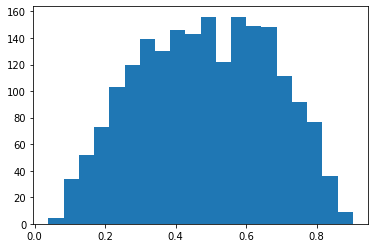

In [41]:
plt.hist(probability[:,1], bins=20)

In [42]:
pd.crosstab(prediction, y_test_2)

Category,Bad,Good
row_0,,
Bad,705,341
Good,284,670


In [43]:
print(f'{accuracy_score(prediction, y_test_2):.4f}', '<- Accuracy')
print(f'{cohen_kappa_score(prediction, y_test_2):.4f}', '<- Kappa')
print(f'{f1_score(prediction, y_test_2, pos_label="Bad"):.4f}', '<- F1')

0.6875 <- Accuracy
0.3753 <- Kappa
0.6929 <- F1


#### F1 analysis

In [44]:
prob_bad = probability[:,0]
for thr in np.arange(0.4, 0.6, 0.01):
    classification = ['Bad' if i > thr else 'Good' for i in prob_bad]
    accuracy = accuracy_score(classification, y_test_2)
    kappa = cohen_kappa_score(classification, y_test_2)
    f1 = f1_score(classification, y_test_2, pos_label='Bad')
    avg =np.mean([accuracy, f1])
    print('Threshold:', f'{thr:.2f}', '| Accuracy:', f'{accuracy:.4f}', '| Kappa:', f'{kappa:.4f}', '| F1:', f'{f1:.4f}', 
          '| Avg:', f'{avg:.4f}')

Threshold: 0.40 | Accuracy: 0.6505 | Kappa: 0.3039 | F1: 0.7042 | Avg: 0.6773
Threshold: 0.41 | Accuracy: 0.6520 | Kappa: 0.3065 | F1: 0.6997 | Avg: 0.6759
Threshold: 0.42 | Accuracy: 0.6530 | Kappa: 0.3083 | F1: 0.6969 | Avg: 0.6750
Threshold: 0.43 | Accuracy: 0.6545 | Kappa: 0.3110 | F1: 0.6938 | Avg: 0.6742
Threshold: 0.44 | Accuracy: 0.6540 | Kappa: 0.3098 | F1: 0.6886 | Avg: 0.6713
Threshold: 0.45 | Accuracy: 0.6610 | Kappa: 0.3235 | F1: 0.6896 | Avg: 0.6753
Threshold: 0.46 | Accuracy: 0.6650 | Kappa: 0.3312 | F1: 0.6892 | Avg: 0.6771
Threshold: 0.47 | Accuracy: 0.6720 | Kappa: 0.3450 | F1: 0.6920 | Avg: 0.6820
Threshold: 0.48 | Accuracy: 0.6770 | Kappa: 0.3548 | F1: 0.6933 | Avg: 0.6851
Threshold: 0.49 | Accuracy: 0.6805 | Kappa: 0.3616 | F1: 0.6912 | Avg: 0.6858
Threshold: 0.50 | Accuracy: 0.6875 | Kappa: 0.3753 | F1: 0.6929 | Avg: 0.6902
Threshold: 0.51 | Accuracy: 0.6855 | Kappa: 0.3710 | F1: 0.6847 | Avg: 0.6851
Threshold: 0.52 | Accuracy: 0.6805 | Kappa: 0.3608 | F1: 0.6748 